# AutoEncoder, Variational AutoEncoder and GAN

In [102]:
import numpy as np
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from typing import Sequence
import datetime
import copy
from os import listdir

## General instructions

Every two weeks you will be given an assignment related to the associated module. There are 3 weekly group sessions available to help you complete the assignments, you are invited to attend one of them each week. Attendance is not mandatory but recommended. However, assignments are graded and not submitting them or submitting them after the deadline will give you no points. The grading system is detailed [here](https://mitt.uib.no/courses/27468/pages/general-information)

**FORMAT**: Jupyter notebook    
**DEADLINE**: Sunday 16th May, 23:59

## Introduction

In this assignment we will go through 3 types of unsupervised neural network: AutoEncoder (AE), Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN). In the first section we will also introduce a new type of layer: the transpose convolution as it is widely used in these unsupervised methods.

Unsupervised have many advantages including the fact that they don't need labels but they are also harder to train... In this assignment it will be totally okay if you don't get good results, we will provide examples of expected results and we don't expect you to spend the entire 2 weeks on the parameter tuning.

## Contents

1. Transpose convolution
2. AutoEncoder
3. Variational AutoEncoder **IN ANOTHER NOTEBOOK COMING SOON**
4. GAN  **IN ANOTHER NOTEBOOK COMING SOON**

## Related videos from the curriculum

- [Lecture 15.1 — From PCA to autoencoders](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69)
- [Lecture 15.2 — Deep autoencoders](https://www.youtube.com/watch?v=6jhhIPdgkp0&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=70) 
- [Lecture 15.3 — Deep autoencoders for document retrieval](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71)
- [Lecture 15.6 — Shallow autoencoders for pre training](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74)
- [Lecture 13 | Generative Models]


## 1. Transpose convolution

**NOTE:** The next sections do not depend on this section, if you are stuck here you can move on to the section 2. :)

--------------------

In this assignment we will use a new type of layer: Transpose Convolution. This layer is typically used when we want to use a neural network to generate images (which is the case for AE, VAE and GAN). To make sure that you understand what it does we ask you to implement a simplified version of the transpose convolution operation. 

TransposeConvolution is NOT the inverse operation of convolution! In mathematics, deconvolution is the operation inverse to convolution! But in machine learning it is often said that TransposeConvolution layers are the symmetric or the inverse of the convolution layers (which is not mathematically true).  The name comes from the fact that the transposed convolution transposes the weight matrix and the input in the actual calculation process compared to the direct convolution.

Surprisingly, Andrew did not make any video about this layer. For some ressource you can check this [blog post](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8) or this [video](https://www.youtube.com/watch?v=QmCxqsbn5B0). Specifically, for an input tensor ``x`` of shape ``(N, C_in, H_in, W_in)`` and a weight tensor ``weights`` of shape ``(C_in, C_out, kernel_size[0], kernel_size[1])`` a transpose convolution layer returns  a tensor ``out`` of shape ``(N, C_out, H_out, W_out)`` (See the *shape* section of [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d) for the formula that gives ``(H_out, W_out)``)), such that:

$$out[n, \; c_{out}, \; h_{start}:h_{end}, \; w_{start}:w_{end}] = \sum_{c_{in} = 0}^{C_{in}-1} x[n, \; c_{in}, \; h, \; w] * weights[c_{in}, \; c_{out}, \; :h_{end}-h_{start}, \; :w_{end}-w_{start}]$$

For:

- $n = 0 ... N - 1$
- $c = 0 ... C_{out} - 1$
- $h = 0 ... H_{in} - 1$
- $w = 0 ... W_{in} - 1$


With:
- $h_{start} = h*stride[0]$
- $w_{start} = w*stride[1]$
- $h_{end} = min(H_{out}, h_{start} + kernel_size[0])$
- $w_{end} = min(W_{out}, w_{start} + kernel_size[1])$

--------------------
## TODO

1. Write a ``get_output_size`` function that takes as parameter an input tensor ``x`` of shape ``(N, C_in, H_in, W_in)``, a tuple of int ``kernel_size`` and a tuple of int ``stride`` and that returns the expected output spatial shape ``(H_out, W_out)`` of the transpose convolution operation. See the *shape* section of [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d) for the formula that gives this output shape (We ignore the padding here, so ``padding=0``)

2. Write a ``apply_transpose_conv`` function that takes as parameter an input tensor ``x`` of shape ``(N, C_in, H_in, W_in)``, a weight tensor ``weights`` of shape ``(C_in, C_out, kernel_size[0], kernel_size[1])`` and a tuple of int ``stride`` and that returns ``out``, a tensor with the right shape and containing the result of the transpose convolution operation between ``x`` and ``weights``. You are of course not allowed to use [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d) not its functional counterpart. 

**NOTE:** We will not really use this function in practice so it's okay to use for loops for the sake of clarity and simplicity in this section

**NOTE:** You will be able to test your functions in the next cell.

In [103]:
def int_to_pair(n):
    """
    Return `(n, n)` if `n` is a int or `n` if `n` is already a tuple of length 2
    """
    # If n is a float or integer
    if not isinstance(n, Sequence):
        return (int(n), int(n))
    elif len(n) == 1:
        return (int(n[0]), int(n[0]))
    elif len(n) == 2:
        return ( int(n[0]), int(n[1]) )
    else:
        raise ValueError("Please give an int or a pair of int")

def get_output_size(x, kernel_size, stride):
    (_, _, H_in, W_in) = x.shape
    H_out = (H_in - 1) * stride[0] + (kernel_size[0] - 1) + 1
    W_out = (W_in - 1) * stride[1] + (kernel_size[1] - 1) + 1
    return (H_out, W_out)


def apply_transpose_conv(x, weights, stride):
    # stride must be pairs of int
    stride = int_to_pair(stride)

    # weights
    (_ , C_out, k_w, k_h) = weights.shape
    kernel_size = [k_w, k_h]

    # get output shape
    (N, C_in, H_in, W_in) = x.shape
    H_out, W_out = get_output_size(x, kernel_size, stride)

    # Initialize output tensor with the right shape 
    out = torch.zeros((N, C_out, H_out, W_out))

    # We will not really use this function in practice so it's okay to use 
    # for loops for the sake of clarity
    print(C_out)
    for n in range(N):
        for c in range(C_out):
            for h in range(H_in):
                for w in range(W_in):
                    h_start = h * stride[0]
                    w_start = w * stride[1]
                    h_end = min(h_start+kernel_size[0], H_out)
                    w_end = min(w_start+kernel_size[1], W_out)
                    out_i = torch.zeros(out[n, c, h_start:h_end,
                                        w_start:w_end].shape)

                    for c_in in range(C_in):
                        out_i += x[n, c_in, h, w] * weights[c_in, c, :h_end-h_start, :w_end-w_start]
                    out[n, c, h_start:h_end, w_start:w_end] += out_i
    return out

def initialize_weights(C_in, C_out, kernel_size):
    """
    Helper function for the tests in the cell below
    """
    kernel_size = int_to_pair(kernel_size)
    len_weights = C_in*C_out*kernel_size[0]*kernel_size[1]
    weights = (torch.arange(len_weights) - len_weights/2)/10
    return weights.reshape(C_in, C_out, kernel_size[0], kernel_size[1])

### Test tranpose convolution 

In [104]:
out1_exp = torch.Tensor([[[[ -30.,  -55.,  -55.,  -25.],
          [ -50.,  -90.,  -90.,  -40.],
          [ -60., -105., -105.,  -45.],
          [ -60., -105., -105.,  -45.],
          [ -30.,  -50.,  -50.,  -20.],
          [ -10.,  -15.,  -15.,   -5.]],
         [[   0.,    5.,    5.,    5.],
          [  10.,   30.,   30.,   20.],
          [  30.,   75.,   75.,   45.],
          [  30.,   75.,   75.,   45.],
          [  30.,   70.,   70.,   40.],
          [  20.,   45.,   45.,   25.]]],
        [[[ -30.,  -55.,  -55.,  -25.],
          [ -50.,  -90.,  -90.,  -40.],
          [ -60., -105., -105.,  -45.],
          [ -60., -105., -105.,  -45.],
          [ -30.,  -50.,  -50.,  -20.],
          [ -10.,  -15.,  -15.,   -5.]],
         [[   0.,    5.,    5.,    5.],
          [  10.,   30.,   30.,   20.],
          [  30.,   75.,   75.,   45.],
          [  30.,   75.,   75.,   45.],
          [  30.,   70.,   70.,   40.],
          [  20.,   45.,   45.,   25.]]]])

out2_exp = torch.Tensor([[[[ 1.87199997e+02,  3.45299988e+02,  3.44749969e+02,  1.57900024e+02],
          [ 3.15900024e+02,  5.73850037e+02,  5.72950012e+02,  2.57650024e+02],
          [ 3.86400024e+02,  6.86250122e+02,  6.85200073e+02,  2.99550049e+02],
          [ 3.84599976e+02,  6.83099976e+02,  6.82049988e+02,  2.98200073e+02],
          [ 1.99200012e+02,  3.41249969e+02,  3.40749939e+02,  1.41950043e+02],
          [ 7.10999832e+01,  1.13749985e+02,  1.13599983e+02,  4.26499939e+01]],
         [[ 1.43999786e+01,  1.52587891e-05,  5.00183105e-02, -1.43000031e+01],
          [-2.87999954e+01, -1.14950035e+02, -1.14650032e+02, -8.58500290e+01],
          [-1.29299973e+02, -3.44249939e+02, -3.43500000e+02, -2.14350006e+02],
          [-1.28399994e+02, -3.42000000e+02, -3.41250000e+02, -2.13000031e+02],
          [-1.41899979e+02, -3.40349976e+02, -3.39650024e+02, -1.97949997e+02],
          [-9.90000000e+01, -2.26150009e+02, -2.25700012e+02, -1.26849998e+02]]],

        [[[ 1.69199982e+02,  3.12300018e+02,  3.11750061e+02,  1.42900024e+02],
          [ 2.85900024e+02,  5.19850098e+02,  5.18950012e+02,  2.33649994e+02],
          [ 3.50400024e+02,  6.23250000e+02,  6.22200012e+02,  2.72549988e+02],
          [ 3.48599945e+02,  6.20099854e+02,  6.19049927e+02,  2.71200012e+02],
          [ 1.81199982e+02,  3.11250031e+02,  3.10750000e+02,  1.29949997e+02],
          [ 6.50999985e+01,  1.04750008e+02,  1.04599998e+02,  3.96500015e+01]],

         [[ 1.44000015e+01,  3.00000763e+00,  3.05000305e+00, -1.12999954e+01],
          [-2.27999954e+01, -9.69499969e+01, -9.66499939e+01, -7.38500214e+01],
          [-1.11299980e+02, -2.99249939e+02, -2.98500031e+02, -1.87350037e+02],
          [-1.10399994e+02, -2.97000000e+02, -2.96250000e+02, -1.86000031e+02],
          [-1.23899971e+02, -2.98350037e+02, -2.97650024e+02, -1.73950012e+02],
          [-8.69999924e+01, -1.99150024e+02, -1.98700012e+02, -1.11850006e+02]]]])
N = 2
H_in = 4
W_in = 3
C_in = 5
C_out = 2

kernel_size = (3,2)
stride = 1

weights = initialize_weights(C_in, C_out, kernel_size)
x1 = torch.ones((N, C_in, H_in, W_in))*10
x2 = torch.arange(120).reshape(N, C_in, H_in, W_in)/10 - 60

print("weights.shape:  ", weights.shape)
print("x.shape:        ", x1.shape)
print("shape expected: ", out1_exp.shape)

out1 = apply_transpose_conv(x1, weights, stride)
print("out1.shape:     ", out1.shape)
out2 = apply_transpose_conv(x2, weights, stride)
print("out2.shape:     ", out2.shape)

print("\nout1 - out1_exp:\n ", out1 - out1_exp)
print("\nout2 - out2_exp:\n ", out2 - out2_exp)

weights.shape:   torch.Size([5, 2, 3, 2])
x.shape:         torch.Size([2, 5, 4, 3])
shape expected:  torch.Size([2, 2, 6, 4])
2
out1.shape:      torch.Size([2, 2, 6, 4])
2
out2.shape:      torch.Size([2, 2, 6, 4])

out1 - out1_exp:
  tensor([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],


        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]]])

out2 - out2_exp:
  tensor([[[[ 0.0000e+00,  0.0000e+00,  3.0518e-05,  0.0000e+00],

# 2. AutoEncoder

*related videos from the curriculum*

- [Lecture 15.1 — From PCA to autoencoders](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69)
- [Lecture 15.2 — Deep autoencoders](https://www.youtube.com/watch?v=6jhhIPdgkp0&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=70) 
- [Lecture 15.3 — Deep autoencoders for document retrieval](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71)
- [Lecture 15.6 — Shallow autoencoders for pre training](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74)
- [Lecture 13 | Generative Models](https://www.youtube.com/watch?v=5WoItGTWV54&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=17) (from 20:40 to 27:05)

An AutoEncoder (AE) is a neural network that is composed of 2 sub-networks: an Encoder and a Decoder. AE can have many purposes but commonly the main objective is to efficiently represent the data that lies on a non-linear manifold. From this point of view, the AutoEncoder can be seen as a generalization of PCA for data that lies on non-linear manifolds as explained in this [video](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69) of the curriculum.

If this is the objective then the Decoder part can be thrown away once the training is done and we can simply use the encoder part to project the data into a latent space of lower dimension ``z_dim`` (in this section, ``z_dim`` will typically be 15 or 30 while the images are 20x20 (=400)). Indeed the Decoder is here just to make sure that the encoding is well done and ensure and faithful representation of the data by comparing the reconstructed (i.e decoded) instances of the compressed (i.e encoded) data with the original data.

### Modules 

In the cell below are defined the following modules that we will need in this section

1. **MyEncoder**
    - input: image
    - output: tensor `z` in latent space (lower dimension than input space)
1. **MyDecoder**
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: reconstructed image
1. **MyAE**
    - input: image
    - output reconstructed image after reduction to latent space
    - attributes:
      - self.encoder = MyEncoder(z_dim)
      - self.decoder = MyDecoder(z_dim)
1. **LeNet5ish**
    Regular image classifier
    - input: image
    - output: label predicted
1. **MyClassifier**
    Classifier on compressed images:
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: label predicted

--------------------
## TODO

1. Take a look at the ``MyEncoder``, ``MyDecoder`` and ``MyAE`` modules. Do the Encoder and Decoder seem really different from any other neural networks so far?


In [105]:
class MyEncoder(nn.Module):
    """
    Encoder module: 
    - input: image
    - output: tensor `z` in latent space (lower dimension than input space)
    """

    def __init__(self, z_dim):
        super().__init__() 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=6, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=5, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=4, kernel_size=4, stride=1)
        self.fc3 = nn.Linear(in_features=256, out_features=z_dim)
        
    def forward(self, x):
        N = x.shape[0]
        out = torch.relu(self.conv1(x))
        out = torch.relu(self.conv2(out))
        out = torch.relu(self.conv3(out))
        out = out.view(N, -1)
        out = torch.relu(self.fc3(out))
        return out

class MyDecoder(nn.Module):
    """
    Decoder module: 
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: reconstructed image
    """
    def __init__(self, z_dim):
        super().__init__() 
        c1 = 3
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 18*18)
        self.transconv3 = nn.ConvTranspose2d(in_channels=1, out_channels=1,  kernel_size=3, stride=1)
        
        
    def forward(self, x):
        N, z_dim = x.shape
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = out.view(N, 1, 18, 18)
        out = torch.sigmoid(self.transconv3(out))
        return out

class MyAE(nn.Module):
    """
    AutoEncoder
    - input: image
    - output reconstructed image after reduction to latent space

    attributes
    - self.encoder = MyEncoder(z_dim)
    - self.decoder = MyDecoder(z_dim)
    """

    def __init__(self, z_dim):
        super().__init__() 
        self.encoder = MyEncoder(z_dim)
        self.decoder = MyDecoder(z_dim)
        
    def forward(self, x):
        self.z = self.encoder(x)
        out = self.decoder(self.z)
        return out


class LeNet5ish(nn.Module):
    """
    Regular image classifier
    - input: image
    - output: label predicted
    """

    def __init__(self, n_labels=10):
        super().__init__() 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=6, kernel_size=5, stride=1)
        self.fc3 = nn.Linear(in_features=864, out_features=120)
        self.fc4 = nn.Linear(in_features=120, out_features=n_labels)
        
    def forward(self, x):
        N = x.shape[0]
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(N, -1)
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        return out

class MyClassifier(nn.Module):
    """
    Classifier on compressed images:
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: label predicted
    """

    def __init__(self, z_dim, n_labels=10):
        super().__init__() 
        c1 = 12
        self.fc1 = nn.Linear(z_dim, 64)
        self.transconv1 = nn.ConvTranspose2d(in_channels=1,  out_channels=c1, kernel_size=3, stride=1)
        self.transconv2 = nn.ConvTranspose2d(in_channels=c1, out_channels=1,  kernel_size=3, stride=1)
        self.fc2 = nn.Linear(144, n_labels)
        
    def forward(self, x):
        N, z_dim = x.shape
        out = F.relu(self.fc1(x))
        out = out.view(N, 1, 8, 8)
        out = F.relu(self.transconv1(out)) 
        out = F.relu(self.transconv2(out))
        out = out.view(N, -1)
        out = F.relu(self.fc2(out))
        return out





### Utils 

Some useful functions:

- **load_MNIST**: Return MNIST train and val dataset
- **training_classifier**: Usual training loop for a classifier
- **validate**: Compute classification accuracies on both train and val dataset
- **plot_true_VS_reconstructed**: Plot side by side original images with their reconstructed counterparts using a trained AE

In [106]:
preprocessor = transforms.Compose([
    transforms.CenterCrop(20),
    transforms.ToTensor(),
    transforms.Normalize(0.2475, 0.3892),
]) 


def load_MNIST(data_path='../data/', transform = preprocessor, labels_kept=[0,1,3,4,8]):
    """
    Return MNIST train and val dataset
    """
    MNIST_train = datasets.MNIST(
        data_path,       
        train=True,      
        download=True,   
        transform=transform
    )

    MNIST_val = datasets.MNIST(
        data_path, 
        train=False,      
        download=True,   
        transform=transform
    )

    print('Size of the original training dataset: ', len(MNIST_train))
    print('Size of the original validation dataset: ', len(MNIST_val))

    if len(labels_kept) <10:
        MNIST_train_reduced = [(img, labels_kept.index(label)) for img, label in MNIST_train if label in labels_kept]
        MNIST_val_reduced = [(img, labels_kept.index(label)) for img, label in MNIST_val if label in labels_kept]

        print('Size of the reduced training dataset: ', len(MNIST_train_reduced))
        print('Size of the reduced validation dataset: ', len(MNIST_val_reduced))
    else:
        MNIST_train_reduced = MNIST_train
        MNIST_val_reduced = MNIST_val

    return MNIST_train_reduced, MNIST_val_reduced


def training_classifier(n_epochs, optimizer, model, loss_fn, train_loader, device=None):
    """
    Usual training loop for a classifier
    """
    if device is None:
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = imgs.to(device=device) 
            labels = labels.to(device=device) 
            batch_size = imgs.shape[0]

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        if epoch == 1 or epoch % 1 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


def validate(model, train_loader, val_loader):
    """
    Compute classification accuracies on both train and val dataset
    """
    accdict = {}
    model.eval()
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

def plot_true_VS_reconstructed(ae, imgs):
    """
    Plot side by side original images with their reconstructed counterpart using a trained AE
    """
    ae.eval()
    N_img = 25
    fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(10,6), sharex=True, sharey=True)
    for i, img in enumerate(imgs[:N_img]):
        with torch.no_grad():
            out = ae(img.unsqueeze(0))
            # True image
            axs.flat[2*i].imshow(img.permute(1, 2, 0), cmap='Greys')
            # Reconstruction
            axs.flat[2*i + 1].imshow(out.squeeze(0).permute(1, 2, 0), cmap='Greys') 
            # Set ax title for the first row
            if i<5:
                axs.flat[2*i].set_title("True\nimage")
                axs.flat[2*i + 1].set_title("AE recon-\nstruction")
    return fig, axs




In [107]:
# Load the data

labels_kept = [i for i in range(10)]
data_train, data_val = load_MNIST(labels_kept=labels_kept)
imgs_train = [img for img, _ in data_train]
label_train = [label for _, label in data_train]
imgs_val = [img for img, _ in data_val]
label_val = [label for _, label in data_val]

Size of the original training dataset:  60000
Size of the original validation dataset:  10000


### Training loop of an AutoEncoder

--------------------
## TODO

1. Write a function ``training_ae`` (you can get inspired by the ``training_classifier`` function in the utils cell above) that trains an auto-encoder. The objective is that the encoder part of the AE gets good at summarizing the data in the latent space and that the decoder gets good at reconstructing the images from the lower dimensional vectors in the latent space.

Note that:
- There is no label in the dataset (so no label in ``train_loader`` neither)
- The loss function is computed by comparing the outputs with the original images. We will typically call this function with loss_fn = `` nn.MSELoss()`` so that each reconstructed pixel is compared to its original couterpart.

In [108]:
def training_ae(n_epochs, optimizer, model, loss_fn, train_loader, device=None):
    """
    Train an AE. No labels required
    """
    #TODO!

### Training your AutoEncoder

Run the cell below to train your AE. You can play with the parameter if you want/need.
Keep in mind that training unsupervised model is not easy and that it is okay in this assignment if you don't get good results at all, we will provide examples of results so that you can still answer the questions).
For this assignment (and in its specific settings) we can say that your AE learns well if your training loss is lower than 0.6. 

In [109]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")
z_dim = 15

ae = MyAE(z_dim=z_dim)
ae.to(device=device)

train_loader_imgs = torch.utils.data.DataLoader(imgs_train, batch_size=512, shuffle=True)
val_loader_imgs = torch.utils.data.DataLoader(imgs_val, batch_size=512, shuffle=True)

lr = 0.5
momentum = 0.6

optimizer = optim.SGD(ae.parameters(), lr=lr, momentum=momentum)
loss_fn = nn.MSELoss()

training_ae(
    n_epochs = 30,
    optimizer = optimizer,
    model = ae,
    loss_fn = loss_fn,
    train_loader = train_loader_imgs,
)

Training on device cuda.


### Plot original images VS reconstruction

--------------------
## TODO

Analyse your results (regardless of how good/bad they might be)

1. Are you satisfied by the reconstructions? If not, what seems to be the problem? Mode collapse? Overfitting? Underfitting? 

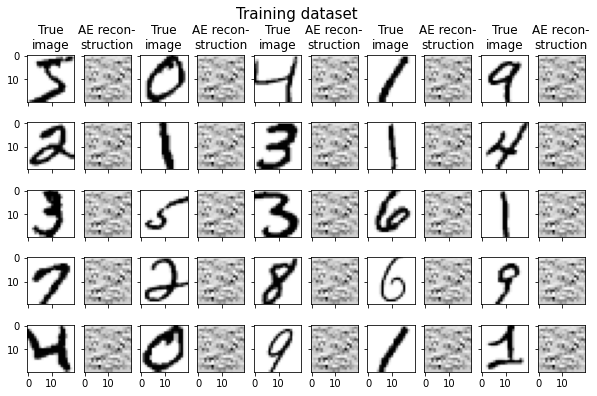

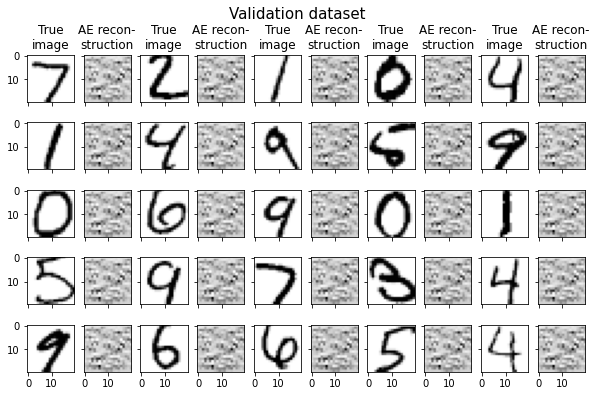

In [110]:
ae.to(device=torch.device('cpu')) 
fig, axs = plot_true_VS_reconstructed(ae, imgs_train)
fig.suptitle("Training dataset", fontsize=15)
plt.show()
fig, axs = plot_true_VS_reconstructed(ae, imgs_val)
fig.suptitle("Validation dataset", fontsize=15)
plt.show()



![Example of AE results on the validation dataset (see train01 image)](./train01.png)


--------------------
## TODO
Analyse the results in the image above.

1. Without looking at the true image, would you say that the reconstructed image looks good?
1. Now take a closer look at the bottom right pair. What can you say? 

### Compress images using the Encoder part of our trained AE

--------------------
## TODO


1. Use the ``transform_images`` function defined in the cell below to compress ``train_loader_imgs`` and ``val_loader_imgs`` and store them in ``compressed_imgs_train`` and ``compressed_imgs_val``. To do so call the function with the encoder part of our AE (accessible using ``ae.encoder``)
2. We have divided by more than 10 the size of the original data, cite some obvious advantages of this compression. 
3. Recalling this [video](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71), this other [video](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74) and this [lecture](https://www.youtube.com/watch?v=5WoItGTWV54&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=16) (from 20:40 to 27:05 ) from the curriculum and the exercise "*CNN: visualization and interpretation, section 3. Last layer: Nearest neighbors*", what could be another application of these compressed data?

In [111]:
def transform_images(model, dataloader, device=None):
    """
    Apply ``model`` to ``dataloader`` and returns the output 
    """
    if device is None:
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model.eval()
    transformed_imgs = []
    for imgs in dataloader:
        with torch.no_grad():
            imgs = imgs.to(device=device) 
            outputs = model(imgs)
            transformed_imgs.append(outputs.clone().detach())
    transformed_imgs = torch.cat(transformed_imgs)
    return transformed_imgs


ae.to(device=device)

train_loader_imgs = torch.utils.data.DataLoader(imgs_train, batch_size=256, shuffle=False) # Keep shuffle to False here otherwise imgs won't correspond to labels anymore
val_loader_imgs = torch.utils.data.DataLoader(imgs_val, batch_size=256, shuffle=False)     # Keep shuffle to False here otherwise imgs won't correspond to labels anymore

# Use the encoder part of our ae to compress our images
compressed_imgs_train = #TODO!
compressed_imgs_val = #TODO!

# Re-associate compressed images with their corresponding labels
data_compressed_train = list(zip(compressed_imgs_train, label_train))
data_compressed_val = list(zip(compressed_imgs_val, label_val))

SyntaxError: invalid syntax (<ipython-input-111-1292db5c41f6>, line 24)

### Classification on compressed images

In the cell below we train ``MyClassifier`` (defined in the "Modules" subsection at the beginning of this section), a classifier that takes as input a tensor `z` in the latent space (lower dimension than the image space) and find the label corresponding to the original image.

In the next cell we evaluate the performance of our classifier.

--------------------
## TODO

1. Recalling that we started from 20x20 (=400) images that were compressed into a 15 dimensional space, are you satisfied by the classification performance? 

In [ ]:
print(f"Training on device {device}.")
epoch = 30
momentum = 0.
lr=0.1


train_loader_compressed = torch.utils.data.DataLoader(data_compressed_train, batch_size=512, shuffle=True)
val_loader_compressed = torch.utils.data.DataLoader(data_compressed_val, batch_size=512, shuffle=True)

classifier_compressed = MyClassifier(z_dim=z_dim, n_labels=len(labels_kept))
classifier_compressed.to(device=device) 
optimizer = optim.SGD(classifier_compressed.parameters(), lr=lr, momentum=momentum)

loss_fn = nn.CrossEntropyLoss()

print(" ============== Training Classifier on compressed images ============== ")
training_classifier(
    n_epochs = epoch,
    optimizer = optimizer,
    model = classifier_compressed,
    loss_fn = loss_fn,
    train_loader = train_loader_compressed,
    device=device,
)


In [ ]:
print(" ============== Classification on compressed images ============== ")
_ = validate(
    model = classifier_compressed,
    train_loader = train_loader_compressed,
    val_loader = val_loader_compressed,
)

### Reconstruct images using the Decoder part of our trained AE

--------------------
## TODO


1. Use the ``transform_images`` function defined earlier to reconstruct ``train_loader_compressed_imgs`` and ``val_loader_compressed_imgs`` and store them in ``reconstructed_imgs_train`` and ``reconstructed_imgs_val``. To do so call the function with the decoder part of our AE (accessible using ``ae.decoder``)

In [ ]:
train_loader_compressed_imgs = torch.utils.data.DataLoader(compressed_imgs_train, batch_size=256, shuffle=False)   # Keep shuffle to False here otherwise imgs won't correspond to labels anymore
val_loader_compressed_imgs = torch.utils.data.DataLoader(compressed_imgs_val, batch_size=256, shuffle=False)       # Keep shuffle to False here otherwise imgs won't correspond to labels anymore

# Use the decoder part of our ae to reconstruct our compressed images
reconstructed_imgs_train = #TODO!
reconstructed_imgs_val = #TODO!

# Re-associate reconstructed images with their corresponding labels
data_reconstructed_train = list(zip(reconstructed_imgs_train, label_train))
data_reconstructed_val = list(zip(reconstructed_imgs_val, label_val))

### Classification on reconstructed images VS true images

In the cell below we train 2 instances of ``LeNet5ish`` (defined in the "Modules" subsection at the beginning of this section), a regular classifier that takes an image and find its corresponding label. The first instance is trained on the reconstructed images and the second one is trained on the original images

In the next cell we evaluate the performance of our classifiers.

--------------------
## TODO

1. Compare the performance of the 2 models. Are you satisfied with the classification on the reconstructed images?
2. If so, can we throw away our original images (and keep only our trained AE and compressed images)? 

In [ ]:
print(f"Training on device {device}.")

epoch = 20
momentum = 0.7
lr=0.07

print(" ============== Training Classifier on reconstructed images ============== ")

train_loader_reconstructed = torch.utils.data.DataLoader(data_reconstructed_train, batch_size=512, shuffle=True)
val_loader_reconstructed = torch.utils.data.DataLoader(data_reconstructed_val, batch_size=512, shuffle=True)

classifier_reconstructed = LeNet5ish(n_labels=len(labels_kept))
classifier_reconstructed.to(device=device) 
optimizer = optim.SGD(classifier_reconstructed.parameters(), lr=lr, momentum=momentum)
loss_fn = nn.CrossEntropyLoss()

training_classifier(
    n_epochs = epoch,
    optimizer = optimizer,
    model = classifier_reconstructed,
    loss_fn = loss_fn,
    train_loader = train_loader_reconstructed,
)

print(" ============== Training Classifier on true images ============== ")

train_loader_true = torch.utils.data.DataLoader(data_train, batch_size=512, shuffle=True)
val_loader_true = torch.utils.data.DataLoader(data_val, batch_size=512, shuffle=True)

classifier_true = LeNet5ish(n_labels=len(labels_kept))
classifier_true.to(device=device) 
optimizer = optim.SGD(classifier_true.parameters(), lr=lr, momentum=momentum)
loss_fn = nn.CrossEntropyLoss()

training_classifier(
    n_epochs = epoch,
    optimizer = optimizer,
    model = classifier_true,
    loss_fn = loss_fn,
    train_loader = train_loader_true,
)


In [ ]:
print(" ============== Classification on reconstructed images ============== ")
_ = validate(
    model = classifier_reconstructed,
    train_loader = train_loader_reconstructed,
    val_loader = val_loader_reconstructed,
)

print(" ============== Classification on true images ============== ")
_ = validate(
    model = classifier_true,
    train_loader = train_loader_true,
    val_loader = val_loader_true,
)

## 3. Variational AutoEncoder  
 
IN ANOTHER NOTEBOOK COMING SOON

## 4. GAN
 
IN ANOTHER NOTEBOOK COMING SOON